# Stocahstic Finance

- ZHANG MIAN
- CentraleSupélec


## 0. Import Libraries

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from scipy.stats import norm
from mpl_toolkits import mplot3d

from scipy.stats import norm
from scipy.stats import jarque_bera

## 1. Define functions in this part.



In [1]:
class Call:

    def __init__(self, s_0=100.0, strike=100.0, t=1.0, r=0.05, sigma=0.2, number_of_simulations=10000, N=1, B=100.0):
        
        # Required parameters for the pricing
        self.s_0 = s_0
        self.strike = strike
        self.t = t
        self.r = r
        self.sigma = sigma
        self.number_of_simulations = number_of_simulations
        self.N=N
        self.h=self.t/self.N
        self.B=B

    def price_monte_carlo(self):
        
        # Normal law N(0,1) pseudorandom draws
        z = np.random.standard_normal(self.number_of_simulations)

        # European Black-Scholes-Merton model Monte Carlo
        s_t = self.s_0 * np.exp(((self.r - (0.5 * self.sigma ** 2)) * self.t) + (self.sigma * np.sqrt(self.t) * z))
        h_t = np.exp(-self.r * self.t)*np.maximum(s_t - self.strike, 0)
        c_0 = np.mean(h_t)
        
        return c_0,h_t,s_t
    
    def heston_price_monte_carlo(self,rho,alpha,nu,v):
        
        # Definition of the asian price vector 
        s_t=np.zeros((self.number_of_simulations,self.N+1))
        v_t=np.zeros((self.number_of_simulations,self.N+1))
        
        # Definition of the rho correlated brownian motion
        z1 = np.random.standard_normal(size=(self.number_of_simulations,self.N))
        z2 = np.random.standard_normal(size=(self.number_of_simulations,self.N))
        b1=z1
        b2=rho*z1+np.sqrt(1-rho**2)*z2
        
        # First price with S0
        v_t[:,0]=np.tile(v,self.number_of_simulations)
        s_t[:,0] = np.tile(np.log(self.s_0),self.number_of_simulations)
        
        # European Call with Heston model
        for i in range(1,self.N+1):
            
            s_t[:,i] = s_t[:,i-1] + ((self.r - (0.5 * v_t[:,i-1] ** 2)) * self.h) + (np.sqrt(v_t[:,i-1]*self.h) * b1[:,i-1])
            v_t[:,i]= np.abs(v_t[:,i-1] - (alpha * (v_t[:,i-1]-v) * self.h) + (nu * np.sqrt(v_t[:,i-1] * self.h) * b2[:,i-1]))
        
        s_t=np.exp(s_t)
        h_t=np.exp(-self.r * self.t)*np.maximum(s_t[:,-1] - self.strike, 0)
        c_0 = np.mean(h_t)
        
        return c_0,h_t,v_t,s_t
    
    def discretisation(self):
        
        # Definition of the asian price vector 
        vec_euler=np.zeros((self.number_of_simulations,self.N+1))
        vec_milstein=np.zeros((self.number_of_simulations,self.N+1))
        vec_bs=np.zeros((self.number_of_simulations,self.N+1))

        
        # Definition of the brownian motion
        z = np.random.standard_normal(size=(self.number_of_simulations,self.N))
        
        # First price with S0
        vec_euler[:,0] = np.tile(self.s_0,self.number_of_simulations)
        vec_milstein[:,0] = np.tile(self.s_0,self.number_of_simulations)
        vec_bs[:,0] = np.tile(self.s_0,self.number_of_simulations)

        # European Call with Heston model
        for i in range(1,self.N+1):
            
            vec_euler[:,i] = vec_euler[:,i-1] + (self.r * vec_euler[:,i-1] * self.h) \
            + (vec_euler[:,i-1] * self.sigma * np.sqrt(self.h) * z[:,i-1])
            
            vec_milstein[:,i] = vec_milstein[:,i-1] + (self.r * vec_milstein[:,i-1] * self.h) \
            + (vec_milstein[:,i-1] * self.sigma * np.sqrt(self.h) * z[:,i-1]) \
            + (0.5 * vec_milstein[:,i-1] * (self.sigma ** 2) * self.h * (z[:,i-1]**2-1))
            
            vec_bs[:,i]=vec_bs[:,0]*np.exp((self.r-0.5*self.sigma**2) * self.h * i \
            +(self.sigma*np.sqrt(self.h*i) * z[:,i-1]))

        return vec_euler,vec_milstein,vec_bs
    
    def euler_trans_density(self,rho,alpha,nu,v):
        
        # Param initialisation
        vec_euler=np.zeros(self.number_of_simulations)
        vec_trans=np.zeros(self.number_of_simulations)
        
        # Definition of a, b and d 
        a=(nu**2)*(1-np.exp(-alpha*self.t))/(4*alpha)
        b=v*np.exp(-alpha*self.t)/a
        d=(4*alpha*v)/(nu**2)
        
        for i in range(self.number_of_simulations):
            
            # Construction of the transition density 
            if d>1:
                vec_trans[i]=a*(np.random.chisquare(d-1,1)+(np.random.standard_normal(1)+np.sqrt(b))**2)
            else:
                p=np.random.poisson(b/2)
                vec_trans[i]=a*np.random.chisquare(d+2*p)
            
            # Simulation of the correlated brownian motion
            z1 = np.random.standard_normal(1)
            z2 = np.random.standard_normal(1)
            z=rho*z1+np.sqrt(1-rho**2)*z2
            
            # Euler process
            vec_euler[i]=np.abs(v - (alpha * (v-v) * self.t) + (nu * np.sqrt(v * self.t) * z))

        return np.sqrt(vec_euler),np.sqrt(vec_trans)
            
            
    def asian_price_monte_carlo(self, anti=False, control=False):
        
        # Definition of the asian price vector 
        s_t=np.array([[0.0]*self.N]*self.number_of_simulations)
        
        # Normal law N(0,1) pseudorandom draws
        if anti==True:
            n=int(self.number_of_simulations/2)
            z1 = np.random.standard_normal(size=(n,self.N))
            z2=-z1
            z=np.concatenate((z1, z2))
        else: 
            z = np.random.standard_normal(size=(self.number_of_simulations,self.N))
        
        # First price with S0
        s_t[:,0] = self.s_0 * np.exp(((self.r - (0.5 * self.sigma ** 2)) * self.h) + (self.sigma * np.sqrt(self.h) * z[:,0]))

        # Asian Black-Scholes-Merton model Monte Carlo
        for i in range(1,self.N):
        
            s_t[:,i] = s_t[:,i-1] * np.exp(((self.r - (0.5 * self.sigma ** 2)) * self.h) + (self.sigma * np.sqrt(self.h) * z[:,i]))
        
        if control==True:
            Z=s_t[:,-1]
            s_t_mean=np.mean(s_t,axis=1)
            h_t=np.exp(-self.r * self.t)*np.maximum(s_t_mean - self.strike, 0)+(Z-np.mean(Z))
            c_0 = np.mean(h_t)
            
        else : 
            s_t_mean=np.mean(s_t,axis=1)
            h_t=np.exp(-self.r * self.t)*np.maximum(s_t_mean - self.strike, 0)
            c_0 = np.mean(h_t)
        
        return c_0,h_t
    
    
    def barrier_price_monte_carlo(self, UO=True):
        
        # Definition of the asian price vector 
        s_t=np.zeros((self.number_of_simulations,self.N))
        
        # Random N(0,1) matrix
        z = np.random.standard_normal(size=(self.number_of_simulations,self.N))
        
        # First price with S0
        s_t[:,0] = self.s_0 * np.exp(((self.r - (0.5 * self.sigma ** 2)) * self.h) + (self.sigma * np.sqrt(self.h) * z[:,0]))

        # Barrier Black-Scholes-Merton model Monte Carlo
        for i in range(1,self.N):
        
            s_t[:,i] = s_t[:,i-1] * np.exp(((self.r - (0.5 * self.sigma ** 2)) * self.h) + (self.sigma * np.sqrt(self.h) * z[:,i]))
        
        # Up and Out 
        if UO==True:
            h_t=np.exp(-self.r * self.t)*np.maximum(s_t[:,-1] - self.strike, 0)*(np.max(s_t,axis=1)<self.B)
            
        # Down and In 
        else:
            h_t=np.exp(-self.r * self.t)*np.maximum(s_t[:,-1] - self.strike, 0)*(np.min(s_t,axis=1)<self.B)

        c_0 = np.mean(h_t)
        
        return c_0,h_t
    
    def barrier_price_monte_carlo_cond(self):
        
        # Definition of the sj and price vector 
        s_t=np.zeros((self.number_of_simulations,self.N+1))
        h_t=np.zeros(self.number_of_simulations)
        
        # Random N(0,1) matrix
        z = np.random.standard_normal(size=(self.number_of_simulations,self.N))
        
        # First price with S0
        s_t[:,0] = np.tile(self.s_0,self.number_of_simulations) 

        # Cnditionnal Monte Carlo iteration
        for j in range(0,self.number_of_simulations):
            
            # Definition of the remain time
            t_index=self.t
            
            # DI B condition
            B_activated=False
            
            # Barrier Black-Scholes-Merton model Monte Carlo Conditionnal
            for i in range(1,self.N+1):
                
                s_t[j,i] = s_t[j,i-1] * np.exp(((self.r - (0.5 * self.sigma ** 2)) * self.h) + (self.sigma * np.sqrt(self.h) * z[j,i-1]))
                
                # If the DI Barrier is reached
                if s_t[j,i]<self.B:
                    B_activated=True
                    t_index=t_index-self.h
                    
                    #s_t[j,-1]=s_t[j,i] * np.exp(((self.r - (0.5 * self.sigma ** 2)) * t_index) + (self.sigma * np.sqrt(t_index) * z[j,-1]))
                    
                    call=Call(s_0=s_t[j,i],
                              strike=self.strike,
                              t=t_index,
                              r=self.r,
                              sigma=self.sigma)
                    
                    h_t[j]=call.price_monte_carlo()[0]
                    
                    break
            
            # If the DI contionnon not reached, we set the last price to 0
            if B_activated==False:
                h_t[j]=0
                    
        #h_t=np.exp(-self.r * self.t)*np.maximum(s_t[:,-1] - self.strike, 0)

        c_0 = np.mean(h_t)
        
        return c_0,h_t
    
    
    def barrier_price_monte_carlo_continuous(self):
    
        # Normal law N(0,1) pseudorandom draws
        z = np.random.standard_normal(self.number_of_simulations)
        u = np.random.uniform(0.0,1.0,self.number_of_simulations)
    
        # Monte Carlo simulations of St
        s_t = self.s_0 * np.exp(((self.r - (0.5 * self.sigma ** 2)) * self.t) + (self.sigma * np.sqrt(self.t) * z))
        
        # We switch to X and simulate the maximum law 
        x_t=np.log(s_t)
        m_t=0.5*(x_t+np.sqrt(np.square(x_t)-(2*self.t*np.log10(u))))
        m_t=np.exp(m_t)
        
        # Final payoff conditionnal to m_t values 
        h_t = np.exp(-self.r * self.t)*np.maximum(s_t - self.strike, 0)*(m_t<self.B)
        c_0 = np.mean(h_t)
        
        return c_0,h_t
    
    
    def price_BS(self):
        
        # European Black-Scholes-Merton model EDP
        d1=(1/(self.sigma*np.sqrt(self.t)))*(np.log(self.s_0/self.strike)+(self.r+(0.5*self.sigma**2))*self.t)
        d2=d1-self.sigma*np.sqrt(self.t)
        c_0=(self.s_0*norm.cdf(d1))-(self.strike*np.exp(-self.r*self.t)*norm.cdf(d2))
        
        return c_0
    
    
    def grecs_BS(self):
        
        d1=(1/(self.sigma*np.sqrt(self.t)))*(np.log(self.s_0/self.strike)+(self.r+0.5*self.sigma)*self.t)
        d2=d1-self.sigma*np.sqrt(self.t)
        
        # Delta 
        delta=norm.cdf(d1)
    
        # Gamma 
        phi_d1=np.exp(-d1**2)/np.sqrt(2*np.pi)
        gamma=phi_d1/(self.s_0*self.sigma*np.sqrt(self.t))
        
        # Vega 
        vega=self.s_0*phi_d1*np.sqrt(self.t)
        
        # Theta 
        theta=-(self.s_0*phi_d1*self.sigma/2*np.sqrt(self.t))-self.r*self.strike*np.exp(-self.r*self.t)*norm.cdf(d2)
        
        # Rho 
        rho=self.strike*self.t*np.exp(-self.r*self.t)*norm.cdf(d2)
        
        return np.array([delta,gamma,vega,theta,rho]),np.array(["Delat","Gamma","Vega","Theta","Rho"])
    
    
    def Euler_EDP(self,L,M,explicit=True):
        
        # We discretise the space dimension and create the y vector
        dy=L/M
        y=np.linspace(0, L, M+1)
        
        # We discretise the time dimension and create the tau vector
        tau=np.linspace(0,self.t,self.N+1)
        
        # Creation of the result matrix
        mat_price=np.zeros((len(y),len(tau)))
        
        # Initial conditions
        mat_price[:,0]=np.maximum(np.exp(y)-self.strike,0)
        
        # Edge conditions
        mat_price[0,1:len(tau)]=0
        mat_price[-1,0:len(tau)]=np.exp(y[-1])-self.strike*np.exp(-self.r*tau)
        
        # We then double loop on the y value and tau value 
        
        # EXPLICIT METHOD
        if explicit==True:
            
            for i in range(1,self.N+1): 
                
                for j in range(1,M):
                    
                    mat_price[j,i]=(1-self.h*(self.sigma**2/dy**2)-self.h*self.r)*mat_price[j,i-1] \
                    +(self.h)/(2*dy**2)*(self.sigma**2-dy*(self.r-(self.sigma**2/2)))*mat_price[j-1,i-1] \
                    +(self.h)/(2*dy**2)*(self.sigma**2+dy*(self.r-(self.sigma**2/2)))*mat_price[j+1,i-1] \
                    
        else:
            
            for i in range(1,self.N+1): 
                
                for j in range(1,M):
                    
                    mat_price[j,i]=(1-self.h*(self.sigma**2/dy**2)-self.h*self.r)*mat_price[j,i-1] \
                    +(self.h)/(2*dy**2)*(self.sigma**2-dy*(self.r-(self.sigma**2/2)))*mat_price[j-1,i-1] \
                    +(self.h)/(2*dy**2)*(self.sigma**2+dy*(self.r-(self.sigma**2/2)))*mat_price[j+1,i-1] \
                        
                
        return mat_price

        
    


In [3]:
def print_grecs(vec_price,mat_grecs,vec_price_option):
    
    plt.figure(1,figsize=(20,10))
    
    plt.subplot(321)
    plt.plot(vec_price, vec_price_option)
    plt.xlabel('Prix S')
    plt.ylabel('Prix Call BS')
    plt.grid(True)
    
    plt.subplot(322)
    plt.plot(vec_price, mat_grecs[:,0])
    plt.xlabel('Prix S')
    plt.ylabel('Delta BS')
    plt.grid(True)
    
    plt.subplot(323)
    plt.plot(vec_price, mat_grecs[:,1])
    plt.xlabel('Prix S')
    plt.ylabel('Gamma BS')
    plt.grid(True)
    
    plt.subplot(324)
    plt.plot(vec_price, mat_grecs[:,2])
    plt.xlabel('Prix S')
    plt.ylabel('Vega BS')
    plt.grid(True)
    
    plt.subplot(325)
    plt.plot(vec_price, mat_grecs[:,3])
    plt.xlabel('Prix S')
    plt.ylabel('Theta BS')
    plt.grid(True)
    
    plt.subplot(326)
    plt.plot(vec_price, mat_grecs[:,4])
    plt.xlabel('Prix S')
    plt.ylabel('Rho BS')
    plt.grid(True)
    
    plt.suptitle("Prix d'un Call BS et Grecques en fonction de S (K=100)")
    
    plt.savefig("grecs_BS.png")
        
    plt.show()
    
    
def print_conv_MC(vec_nb_simul,vec_price_BS,vec_price_MC,IC_haut,IC_bas):
    
    plt.figure(1,figsize=(20,10))
    plt.title("Convergence du prix BS et Monte Carlo ")
    plt.plot(vec_nb_simul, IC_haut,label='IC',color='g',ls='--')
    plt.plot(vec_nb_simul, IC_bas,color='g',ls='--')
    plt.plot(vec_nb_simul, vec_price_MC,label='MC')
    plt.plot(vec_nb_simul, vec_price_BS,label='BS',color='r')

    plt.xlabel('Nombre Simulations')
    plt.ylabel('Prix Call')
    plt.xscale('log')
    
    plt.grid(True)
    plt.legend()
    
    plt.savefig("conv_MC.png")
        
    plt.show()
    
def print_hist_MC(MC_Norm):
    
    plt.figure(1,figsize=(10,5))
    
    plt.hist(MC_Norm,edgecolor = 'black')
    plt.title('Distribution empirique des prix Monte Carlo normalisé')

    plt.savefig("MC_Norm.png")
    plt.show()
    
def print_conv_jb(vec_nb_simul,mat_jb_test):
    
    plt.figure(1,figsize=(20,10))
    
    plt.subplot(211)
    plt.plot(vec_nb_simul, mat_jb_test[:,0])
    plt.xlabel('Nombre de simulations')
    plt.ylabel('JB Stat')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True)
    
    plt.subplot(212)
    plt.plot(vec_nb_simul, mat_jb_test[:,1])
    plt.xlabel('Nombre de simulations')
    plt.ylabel('P-value')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True)

    plt.suptitle("Convergence de l'estimateur de Monte Carlo normalisé")
    
    plt.savefig("conv_JB.png")
        
    plt.show()
    
def print_asian_S0(vec_price,vec_price_option):
    
    plt.figure(1,figsize=(20,10))
    
    plt.plot(vec_price, vec_price_option)
    plt.xlabel('Prix S')
    plt.ylabel('Prix Asian Call')
    plt.grid(True)
    
    plt.title("Prix d'une option asiatique en fonction de S0")
    plt.savefig("asian_S0.png")
    plt.show()
    
def print_asian_N(vec_N,vec_price_option):
        
    plt.figure(1,figsize=(20,10))
    
    plt.plot(vec_N, vec_price_option)
    plt.xlabel('Nombre Observations')
    plt.ylabel('Prix Asian Call')
    plt.xscale('log')
    plt.grid(True)
    
    plt.title("Prix d'une option asiatique en fonction de N")
    plt.savefig("asian_N.png")
    plt.show()
    
def print_conv_Euler(vec_N,vec_err_forte,vec_err_faible):
    
    plt.figure(1,figsize=(20,10))
    
    plt.subplot(211)
    plt.plot(vec_N, vec_err_forte)
    plt.xlabel('Nombre de discretisation')
    plt.ylabel('Erreur forte')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True)
    
    plt.subplot(212)
    plt.plot(vec_N, vec_err_faible)
    plt.xlabel('Nombre de discretisation')
    plt.ylabel('Erreur faible')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True)

    plt.suptitle("Convergence du schema d'Euler-Maruyama")
    
    plt.savefig("conv_Euler.png")
        
    plt.show()
    
def print_conv_Milstein(vec_N,vec_err_forte,vec_err_faible):
    
    plt.figure(1,figsize=(20,10))
    
    plt.subplot(211)
    plt.plot(vec_N, vec_err_forte)
    plt.xlabel('Nombre de discretisation')
    plt.ylabel('Erreur forte')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True)
    
    plt.subplot(212)
    plt.plot(vec_N, vec_err_faible)
    plt.xlabel('Nombre de discretisation')
    plt.ylabel('Erreur faible')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True)

    plt.suptitle("Convergence du schema de Milstein")
    
    plt.savefig("conv_Milstein.png")
        
    plt.show()
    
    
def plot_smile_vol(vec_K,vec_implied_vol):
            
    plt.figure(1,figsize=(20,10))
    
    plt.plot(vec_K, vec_implied_vol,'ro-')
    plt.xlabel('Strike')
    plt.ylabel('Vol Implicite')
    plt.grid(True)
    
    plt.title("Volatilité Implicite Heston, T=1 ")
    plt.savefig("smile_vol.png")
    plt.show()
    
    
def plot_nappe_vol(vec_K,vec_T,mat_implied_vol):
           
    # Creating figure     
    fig=plt.figure(1,figsize=(10,10))
    ax=plt.axes(projection ='3d')
    
    # Creating color map
    my_cmap = plt.get_cmap('plasma')
    
    # Creating plot
    surf=ax.plot_surface(vec_K, vec_T, mat_implied_vol,cmap = my_cmap,edgecolor ='none')
    fig.colorbar(surf, ax = ax)
    
    ax.set_xlabel('Strike')
    ax.set_ylabel('Maturite')
    ax.set_zlabel('Vol')
    
    ax.set_title('Surface de volatilite')
    
    plt.savefig("nappe_vol.png")
    plt.show()
    
def plot_color_map(vec_K,vec_T,mat_implied_vol):
           
    # Creating figure     
    fig=plt.figure(1,figsize=(20,10))
    p=plt.pcolormesh(vec_T,vec_K,mat_implied_vol,cmap="plasma")
    fig.colorbar(p)
    
    plt.xlabel('Maturite')
    plt.ylabel('Strike')
    plt.title('Surface de volatilite')
    
    plt.savefig("colormap_vol.png")
    plt.show()


def print_vol_lambda(vec_param,vec_K,mat_implied_vol_param):
    
    plt.figure(1,figsize=(20,10))
    plt.plot(vec_K, mat_implied_vol_param,label=vec_param)

    plt.xlabel('Strike')
    plt.ylabel('Vol Implicite')
    
    plt.grid(True)
    plt.title("Volatilite Implicite et Lambda")
    
    plt.legend()
    
    plt.savefig("vol_lambda.png")
    plt.show()
    
def print_vol_nu(vec_param,vec_K,mat_implied_vol_param):
    
    plt.figure(1,figsize=(20,10))
    plt.plot(vec_K, mat_implied_vol_param,label=vec_param)

    plt.xlabel('Strike')
    plt.ylabel('Vol Implicite')
    
    plt.grid(True)
    plt.title("Volatilite Implicite et Nu")
    
    plt.legend()
    
    plt.savefig("vol_nu.png")
    plt.show()

def print_vol_rho(vec_param,vec_K,mat_implied_vol_param):
    
    plt.figure(1,figsize=(20,10))
    plt.plot(vec_K, mat_implied_vol_param,label=vec_param)

    plt.xlabel('Strike')
    plt.ylabel('Vol Implicite')
    
    plt.grid(True)
    plt.title("Volatilite Implicite et Rho")
    
    plt.legend()
    
    plt.savefig("vol_rho.png")
    plt.show()

def print_hist_sigma(mat_v):
        
    fig, axs = plt.subplots(1, 2, sharey=True,tight_layout=True,figsize=(10,10))

    axs[0].hist(mat_v[0],edgecolor = 'black',bins=20)
    axs[0].set_title('Schema d Euler')
    
    axs[1].hist(mat_v[1],edgecolor = 'black',bins=20)
    axs[1].set_title('Densite de transition')
        
    plt.savefig("hist_v.png")
        
    plt.show()
    
def print_UO_S0(vec_S0, vec_UO, vec_BS):

     plt.figure(1,figsize=(20,10))
     plt.title("Prix d'un call standard VS prix d'un call UO (B=200)")
     plt.plot(vec_S0, vec_UO,label='Call UO')
     plt.plot(vec_S0, vec_BS,label='Call BS')
    
     plt.xlabel('S0')
     plt.ylabel('Prix')
     
     plt.grid(True)
     plt.legend()
     
     plt.savefig("UO_S0.png")
     
     plt.show()
     
def print_DI_S0(vec_S0, vec_DI, vec_BS):

     plt.figure(1,figsize=(20,10))
     plt.title("Prix d'un call standard VS prix d'un call DI (B=100)")
     plt.plot(vec_S0, vec_DI,label='Call DI')
     plt.plot(vec_S0, vec_BS,label='Call BS')
    
     plt.xlabel('S0')
     plt.ylabel('Prix')
     
     plt.grid(True)
     plt.legend()
     
     plt.savefig("DI_S0.png")
     
     plt.show()
     
def print_UO_N(vec_N,vec_UO,vec_UO_cont):
        
    plt.figure(1,figsize=(20,10))
    
    plt.plot(vec_N, vec_UO,label='Discrete')
    plt.plot(vec_N, vec_UO_cont,label='Continuous')
    
    plt.xlabel('Nombre d Observations')
    plt.ylabel('Prix Call UO')
    
    plt.xscale('log')
    plt.grid(True)
    plt.legend()
    
    plt.title("Prix d'un call UO en fonction de N (B=150)")
    plt.savefig("UO_N.png")
    plt.show()


def print_Euler_S0(vec_S0, vec_Euler, vec_BS):

     plt.figure(1,figsize=(20,10))
     plt.title("Prix d'un call standard EDP VS B&S en fonction de S0")
     plt.plot(vec_S0, vec_Euler,label='Call EDP')
     plt.plot(vec_S0, vec_BS,label='Call BS')
    
     plt.xlabel('S0')
     plt.ylabel('Prix')
     
     plt.grid(True)
     plt.legend()
     
     plt.savefig("Euler_S0.png")
     
     plt.show()
     
def print_error_N(vec_N, mat_error):
    
    plt.figure(1,figsize=(20,15))
    plt.suptitle("Erreur moyenne du prix en fonction de N (M=100)")
    
    plt.subplot(311)
    plt.plot(vec_N, mat_error[:,0])
    plt.xlabel('N')
    plt.ylabel('Erreur L1')
    plt.xscale('log')
    #plt.yscale('log')
    plt.grid(True)
    
    plt.subplot(312)
    plt.plot(vec_N, mat_error[:,1])
    plt.xlabel('N')
    plt.ylabel('Erreur L2')
    plt.xscale('log')
    #plt.yscale('log')
    plt.grid(True)
    
    plt.subplot(313)
    plt.plot(vec_N, mat_error[:,2])
    plt.xlabel('N')
    plt.ylabel('Erreur LInf')
    plt.xscale('log')
    #plt.yscale('log')
    plt.grid(True)
        
    plt.savefig("error_N.png")
    
    plt.show()
    
def print_error_M(vec_M, mat_error):
    
    plt.figure(1,figsize=(20,15))
    plt.suptitle("Erreur moyenne du prix en fonction de M (N=100)")
    
    plt.subplot(311)
    plt.plot(vec_M, mat_error[:,0])
    plt.xlabel('M')
    plt.ylabel('Erreur L1')
    plt.xscale('log')
    #plt.yscale('log')
    plt.grid(True)
    
    plt.subplot(312)
    plt.plot(vec_M, mat_error[:,1])
    plt.xlabel('M')
    plt.ylabel('Erreur L2')
    plt.xscale('log')
    #plt.yscale('log')
    plt.grid(True)
    
    plt.subplot(313)
    plt.plot(vec_M, mat_error[:,2])
    plt.xlabel('M')
    plt.ylabel('Erreur LInf')
    plt.xscale('log')
    #plt.yscale('log')
    plt.grid(True)
        
    plt.savefig("error_M.png")
    
    plt.show()
    
def print_error_ponc(vec_S0,vec_t,mat_euler):
           
    # Creating figure     
    fig=plt.figure(1,figsize=(20,10))
    p=plt.pcolormesh(vec_t,vec_S0,mat_euler,cmap="plasma")
    fig.colorbar(p)
    
    plt.xlabel('t')
    plt.ylabel('St')
    plt.title('Erreur ponctuelle')
    
    plt.savefig("error_ponc.png")
    plt.show()

##2. The Monte-Carlo simulation and Black-Scholes.
- Implement the price of Black-Scholes and Calculate the Greeks with $S_0$.
- Implement the Monte-Carlo and observe the convergence.
- Verify and show the normal distribution of Monte-Carlo.
- Verify and show the speed of converge.


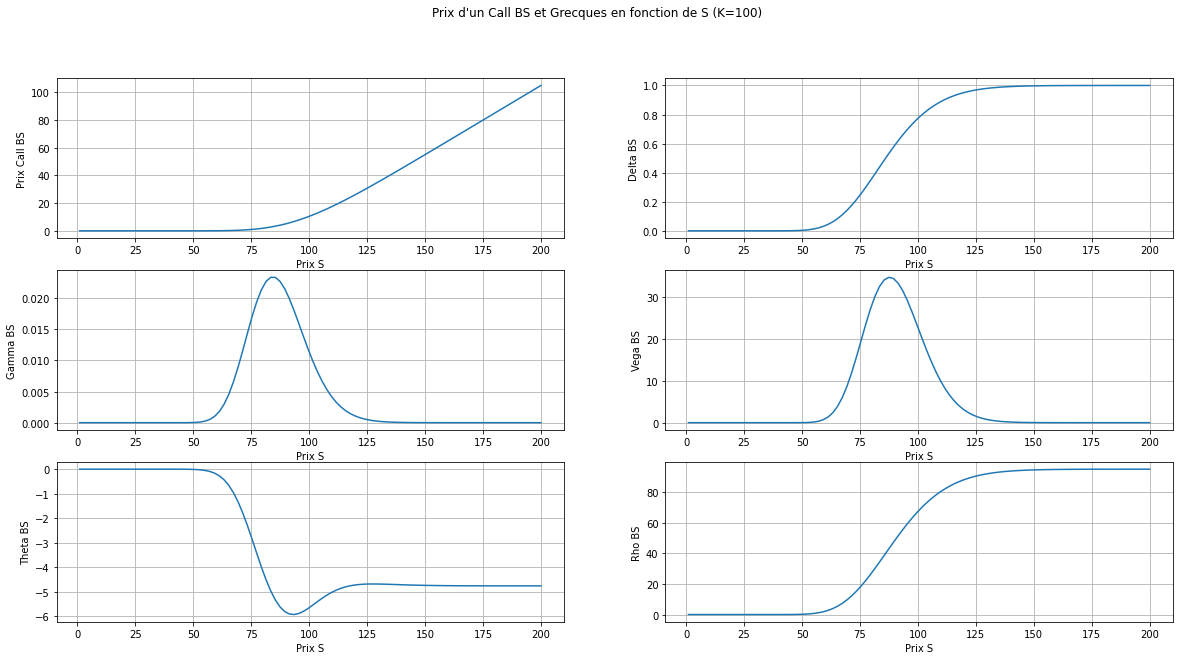

In [5]:
vec_price = np.linspace(1,200,num=100)
vec_price_call=np.array([0.0]*100)
mat_grecs=np.array([[0.0]*5]*100)

for i in range(len(vec_price)):
    call=Call(s_0=vec_price[i], strike=100.0, t=1.0, r=0.05, sigma=0.2, number_of_simulations=100000)
    vec_price_call[i]=call.price_BS()
    mat_grecs[i]=call.grecs_BS()[0]
    
print_grecs(vec_price,mat_grecs,vec_price_call)

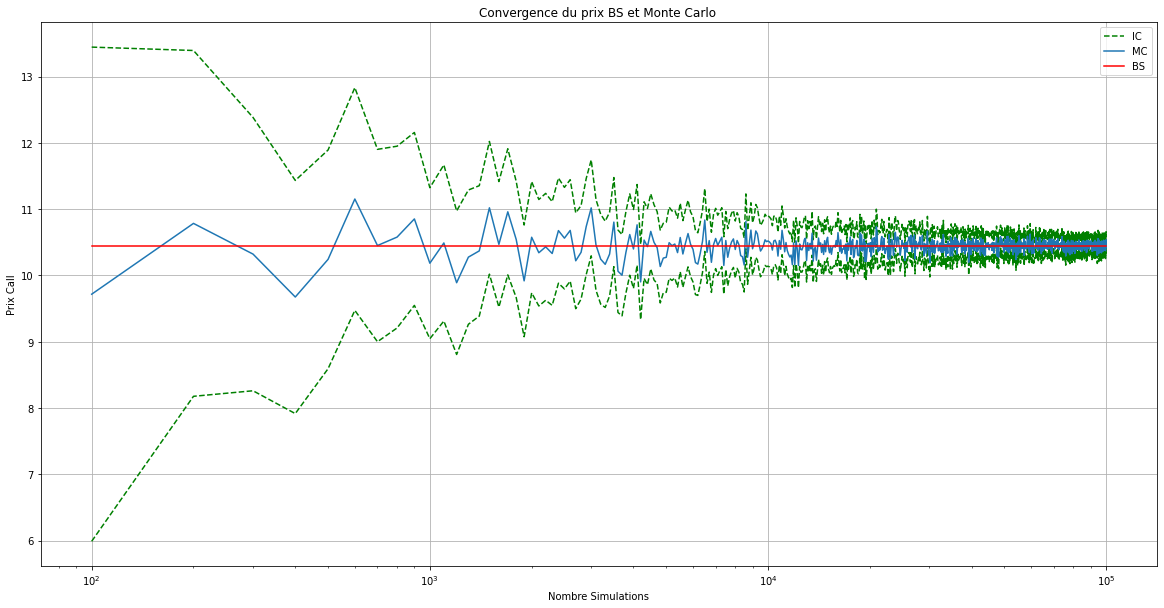

In [7]:
vec_nb_simul=np.linspace(100,100000,1000)
vec_price_BS=np.array([0.0]*1000)
vec_price_MC=np.array([0.0]*1000)
vec_var_prix_MC=np.array([0.0]*1000)

IC_haut=np.array([0.0]*1000)
IC_bas=np.array([0.0]*1000)

alpha=0.01
q=norm.ppf(1-alpha/2)

for i in range(len(vec_nb_simul)):
    call=Call(s_0=100, strike=100.0, t=1.0, r=0.05, sigma=0.2, number_of_simulations=int(vec_nb_simul[i]))
    vec_price_BS[i]=call.price_BS()
    prix_MC=call.price_monte_carlo()
    vec_price_MC[i]=prix_MC[0]
    vec_var_prix_MC[i]=(1/(vec_nb_simul[i]-1))*np.sum((prix_MC[1]-prix_MC[0])**2)
    IC_haut[i]=prix_MC[0]+q*np.sqrt(vec_var_prix_MC[i]/vec_nb_simul[i])    
    IC_bas[i]=prix_MC[0]-q*np.sqrt(vec_var_prix_MC[i]/vec_nb_simul[i])    

print_conv_MC(vec_nb_simul,vec_price_BS,vec_price_MC,IC_haut,IC_bas)

Condiser 10000 simulations of the price of Monte Carlo, each obtain a large number of simulation of payoff and show the histogram.


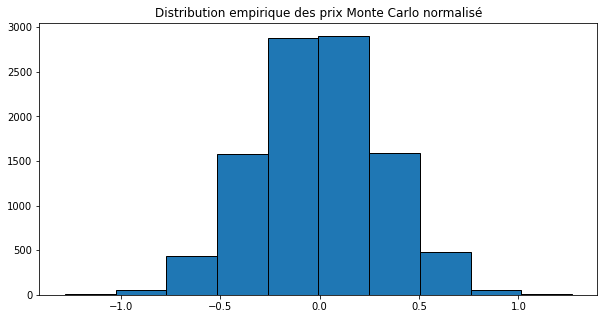

In [8]:
vec_price_MC=np.array([0.0]*10000)
vec_var_prix_MC=np.array([0.0]*10000)

for i in range(10000):
    call=Call(s_0=100, strike=100.0, t=1.0, r=0.05, sigma=0.2, number_of_simulations=100000)
    prix_MC=call.price_monte_carlo()
    vec_price_MC[i]=prix_MC[0]
    vec_var_prix_MC[i]=(1/(100000-1))*np.sum((prix_MC[1]-prix_MC[0])**2)   
    
MC_Norm=(vec_price_MC-np.mean(vec_price_MC))/(np.sqrt(vec_var_prix_MC/10000))

print_hist_MC(MC_Norm)

In [11]:
jb_test=jarque_bera(MC_Norm)
print("The test statistic is",round(jb_test[0],4),"and the corresponding p-value is"
      ,round(jb_test[1],4),".") 
print('')

The test statistic is 0.1542 and the corresponding p-value is 0.9258 .



- Since this p-value is not less than 0.05, we fail to reject the null hypothesis. 

- We don’t have sufficient evidence to say that this data is significantly different from a normal distribution.

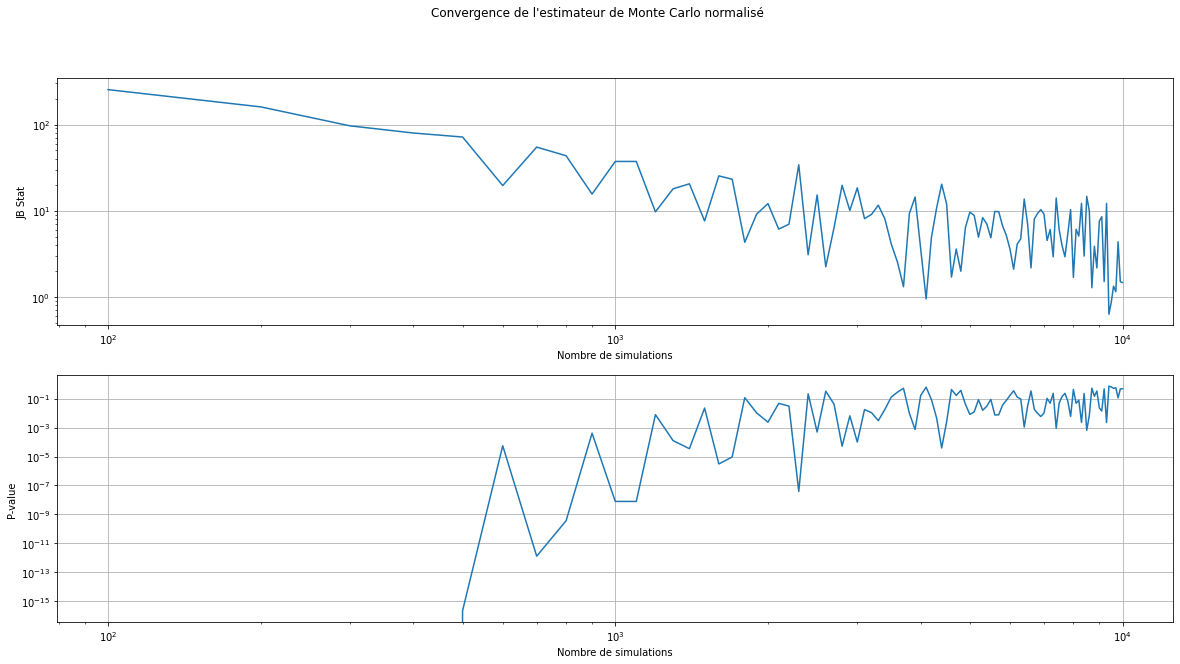

In [12]:
mat_jb_test=np.array([[0.0]*2]*100)
vec_nb_simul=np.linspace(100,10000,100)

for i in range(len(vec_nb_simul)):
    
    vec_price_MC=np.array([0.0]*10000)
    vec_var_prix_MC=np.array([0.0]*10000)
    
    for j in range(10000):
        call=Call(s_0=100, strike=100.0, t=1.0, r=0.05, sigma=0.2, number_of_simulations=int(vec_nb_simul[i]))
        prix_MC=call.price_monte_carlo()
        vec_price_MC[j]=prix_MC[0]
        vec_var_prix_MC[j]=np.var(prix_MC[1])
        
    MC_Norm=(vec_price_MC-np.mean(vec_price_MC))/(np.sqrt(vec_var_prix_MC/10000))
    mat_jb_test[i,:]=jarque_bera(MC_Norm)
    
print_conv_jb(vec_nb_simul,mat_jb_test)

## 2. Asian Option 
- Draw the price of the asian option with the variation of {S_0}.
- Draw the price of the asian option with the variation of maturity.
- Analyse the method of reduce variance for the asian option.

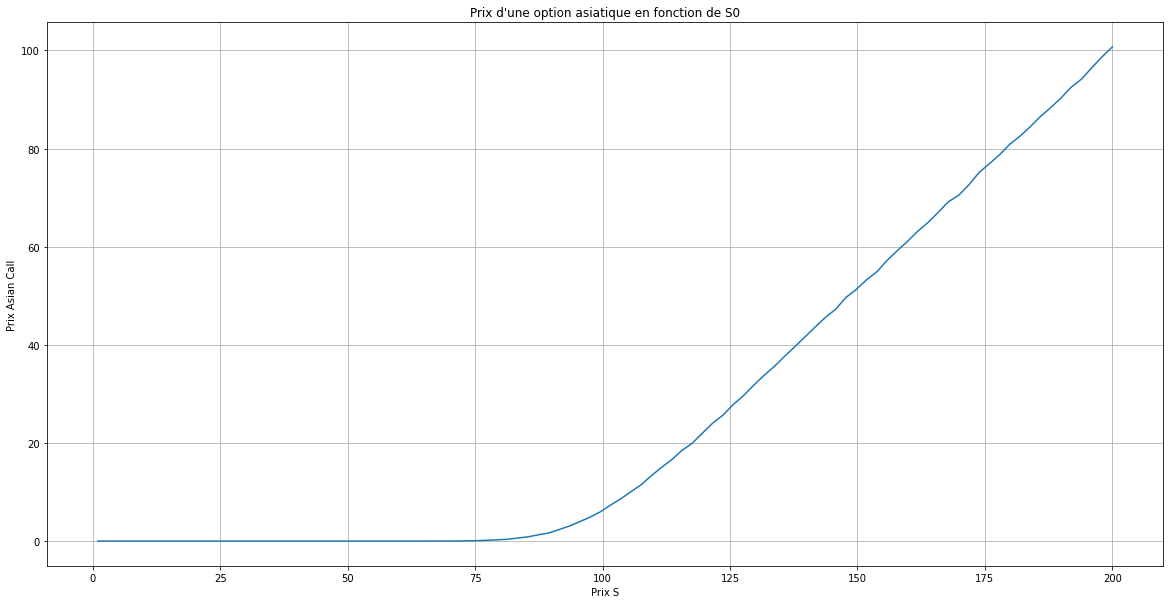

In [13]:
vec_price = np.linspace(1,200,num=100)
vec_price_call=np.array([0.0]*100)

for i in range(len(vec_price)):
    call=Call(s_0=vec_price[i], strike=100.0, t=1.0, r=0.05, sigma=0.2, number_of_simulations=10000, N=10)
    vec_price_call[i]=call.asian_price_monte_carlo()[0]

print_asian_S0(vec_price, vec_price_call)

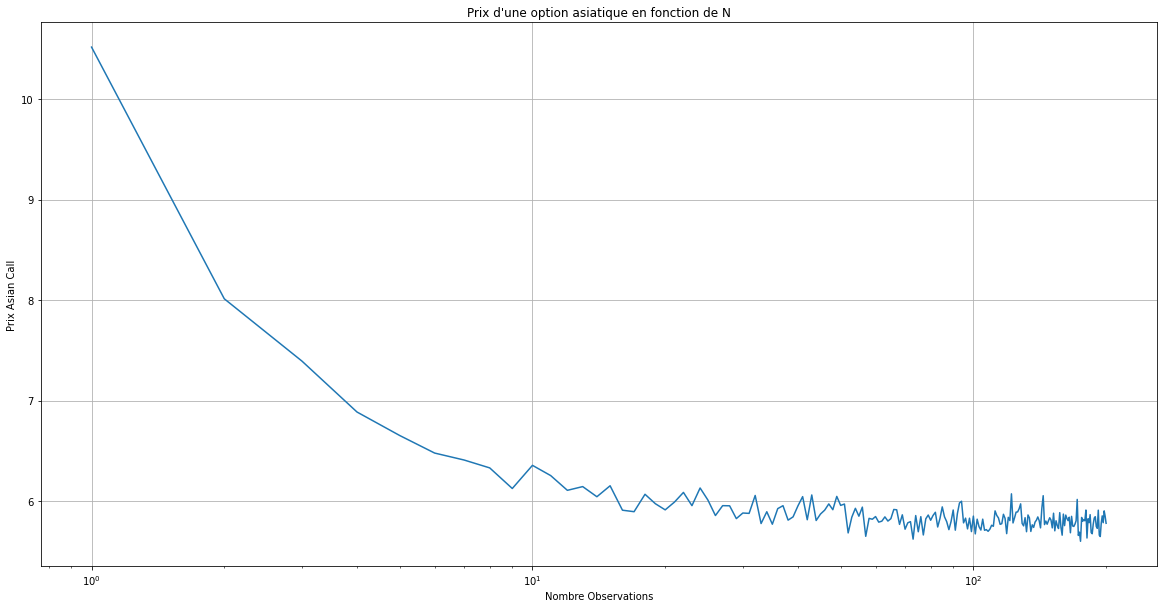

In [14]:
vec_N = np.linspace(1,200,num=200)
vec_price_call=np.array([0.0]*200)

for i in range(len(vec_N)):
    call=Call(s_0=100.0, strike=100.0, t=1.0, r=0.05, sigma=0.2, number_of_simulations=10000, N=int(vec_N[i]))
    vec_price_call[i]=call.asian_price_monte_carlo()[0]

print_asian_N(vec_N, vec_price_call)

In [15]:
#   METHODE : VARIABLES ANTITHETIQUE

# Initialisation des vecteurs de résultats
vec_price=np.array([0.0]*1000)
vec_price_anti=np.array([0.0]*1000)

# Initialisation du call
call=Call(s_0=100.0, strike=100.0, t=1.0, r=0.05, sigma=0.2, number_of_simulations=10000, N=10)

for i in range(1000):
    
    # Calcul du vecteur de prix classique
    vec_price[i]=call.asian_price_monte_carlo()[0]
    # Calcul du vecteur de prix antithétique
    vec_price_anti[i]=call.asian_price_monte_carlo(anti=(True))[0]

print('Méthode anthitétique : ')
print('Variance de l estimateur simple : %.4f' % (np.var(vec_price)))
print('Variance de l estimateur antithétique : %.4f' % (np.var(vec_price_anti)))
print('')

#   METHODE : VARIABLES DE CONTROLE

''' Considérons 10 000 simulation de payoff et comparons la variance de l'estimateur 
    classique avec celle de l'estimateur de contrôle (n=1000). 
    On considère Z = ST. '''

# Initialisation des vecteurs de résultats
vec_price=np.array([0.0]*1000)
vec_price_cc=np.array([0.0]*1000)

# Initialisation du call
call=Call(s_0=100.0, strike=100.0, t=1.0, r=0.05, sigma=0.2, number_of_simulations=10000, N=10)

for i in range(1000):
      # Calcul du vecteur de prix classique
    vec_price[i]=call.asian_price_monte_carlo()[0]
    # Calcul du vecteur de prix de contrôle
    vec_price_cc[i]=call.asian_price_monte_carlo(control=(True))[0]

print('Méthode de contrôle :')
print('Variance de l estimateur simple : %.4f' % (np.var(vec_price)))
print('Variance de l estimateur de contrôle : %.4f' % (np.var(vec_price_cc)))
print('')

Méthode anthitétique : 
Variance de l estimateur simple : 0.0076
Variance de l estimateur antithétique : 0.0036

Méthode de contrôle :
Variance de l estimateur simple : 0.0073
Variance de l estimateur de contrôle : 0.0074



## 4. Numerical Method

- The method for Black-Scholes.
- The partial differential equation of the Black Scholes
- Draw the average error of the price with the variation of N.
- Draw the average error of the price with the variation of M.
- Plotting the point error



In [ ]:
call=Call(s_0=100.0, 
                       strike=100.0, 
                       t=1.0, 
                       r=0.05, 
                       sigma=0.2,
                       N=100)

# Explicit Euler resolution
price=call.Euler_EDP(L=6, M=100, explicit=True)

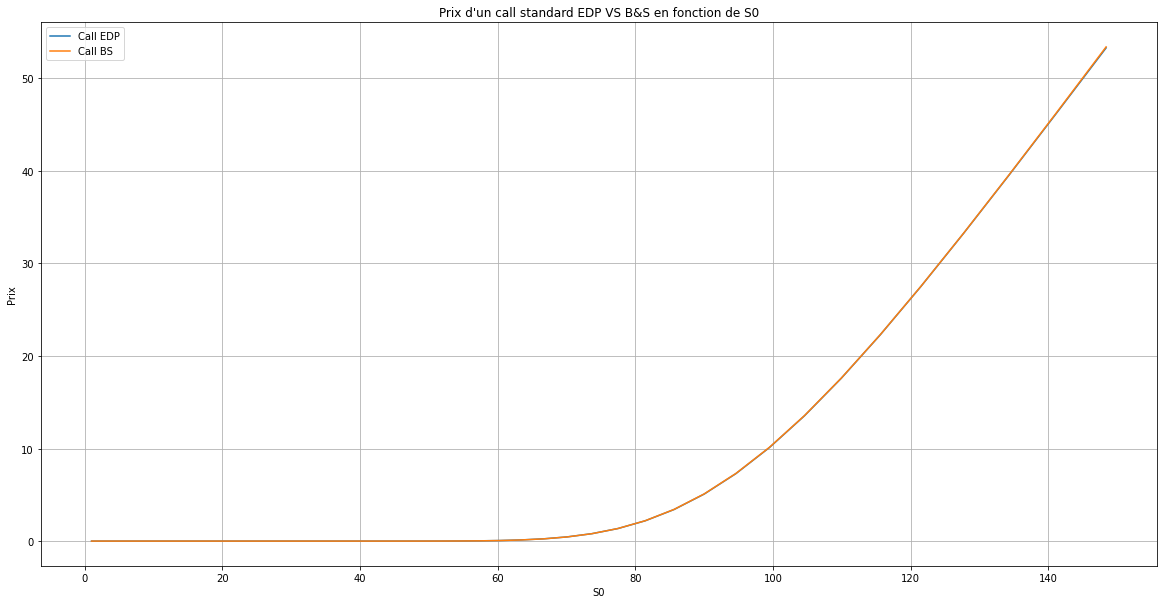

In [20]:
# Initialise the vectors
log_s_max=5 
vec_L=np.linspace(0, log_s_max,101)
vec_S0=np.exp(vec_L)
price_BS=np.zeros(len(vec_S0))

# Intilize option object for Euler price
call=Call(s_0=100.0, 
                       strike=100.0, 
                       t=1.0, 
                       r=0.05, 
                       sigma=0.2,
                       N=100)

# Explicit Euler resolution
mat_Euler=call.Euler_EDP(L=log_s_max, M=100, explicit=True)

# Iteration to get the BS price 
for i in range(len(price_BS)):
    
    # Initialize option object
    call=Call(s_0=vec_S0[i], 
                           strike=100.0, 
                           t=1.0, 
                           r=0.05, 
                           sigma=0.2)
    # BS price
    price_BS[i]=call.price_BS()
    
# Plot the graph
print_Euler_S0(vec_S0, mat_Euler[:,-1], price_BS)

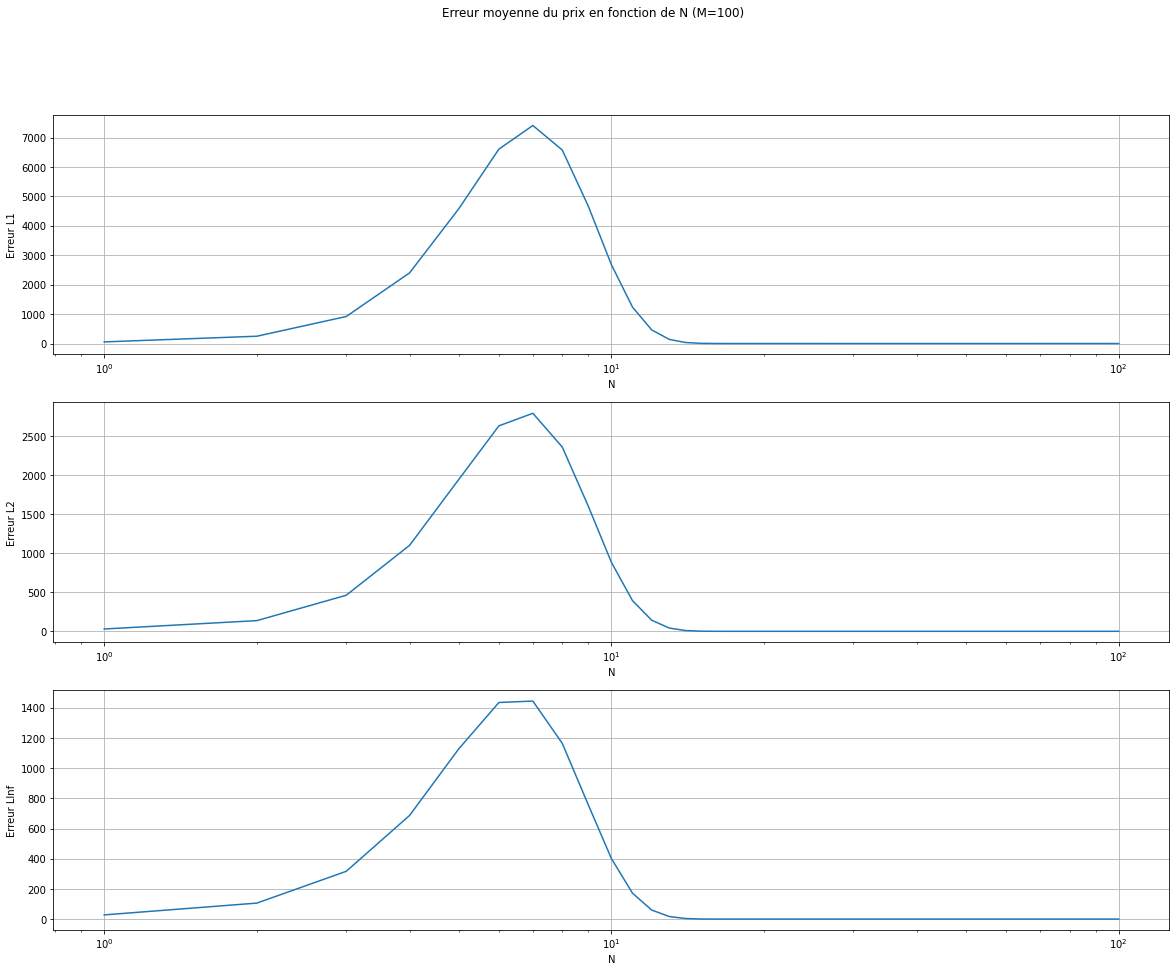

In [21]:
# Initialise the results matrix and time vector 
vec_N=np.linspace(1,100,100)
mat_error=np.zeros((len(vec_N),3))

log_s_max=5
vec_L=np.linspace(0,log_s_max,101)
vec_S0=np.exp(vec_L)
price_BS=np.zeros(len(vec_L))

# Iteration to get the BS price 
for j in range(len(vec_L)):
    
    # Initialize option object
    call=Call(s_0=vec_S0[j], 
                           strike=100.0, 
                           t=1.0, 
                           r=0.05, 
                           sigma=0.2)
    
    # BS price
    price_BS[j]=call.price_BS()

# We loop on the N values
for i in range(len(vec_N)):
    
    # Intilize option object for Euler price
    call=Call(s_0=100.0, 
                           strike=100.0, 
                           t=1.0, 
                           r=0.05, 
                           sigma=0.2,
                           N=int(vec_N[i]))

    # Explicit Euler resolution
    mat_Euler=call.Euler_EDP(L=log_s_max, M=len(vec_L)-1, explicit=True)
        
    # Calculus of the error
    mat_error[i,0]=np.sum(np.abs(mat_Euler[:,-1]-price_BS))
    mat_error[i,1]=np.sqrt(np.sum((mat_Euler[:,-1]-price_BS)**2))
    mat_error[i,2]=np.max(np.abs(mat_Euler[:,-1]-price_BS))
        
    
#Plot the graph
print_error_N(vec_N, mat_error)

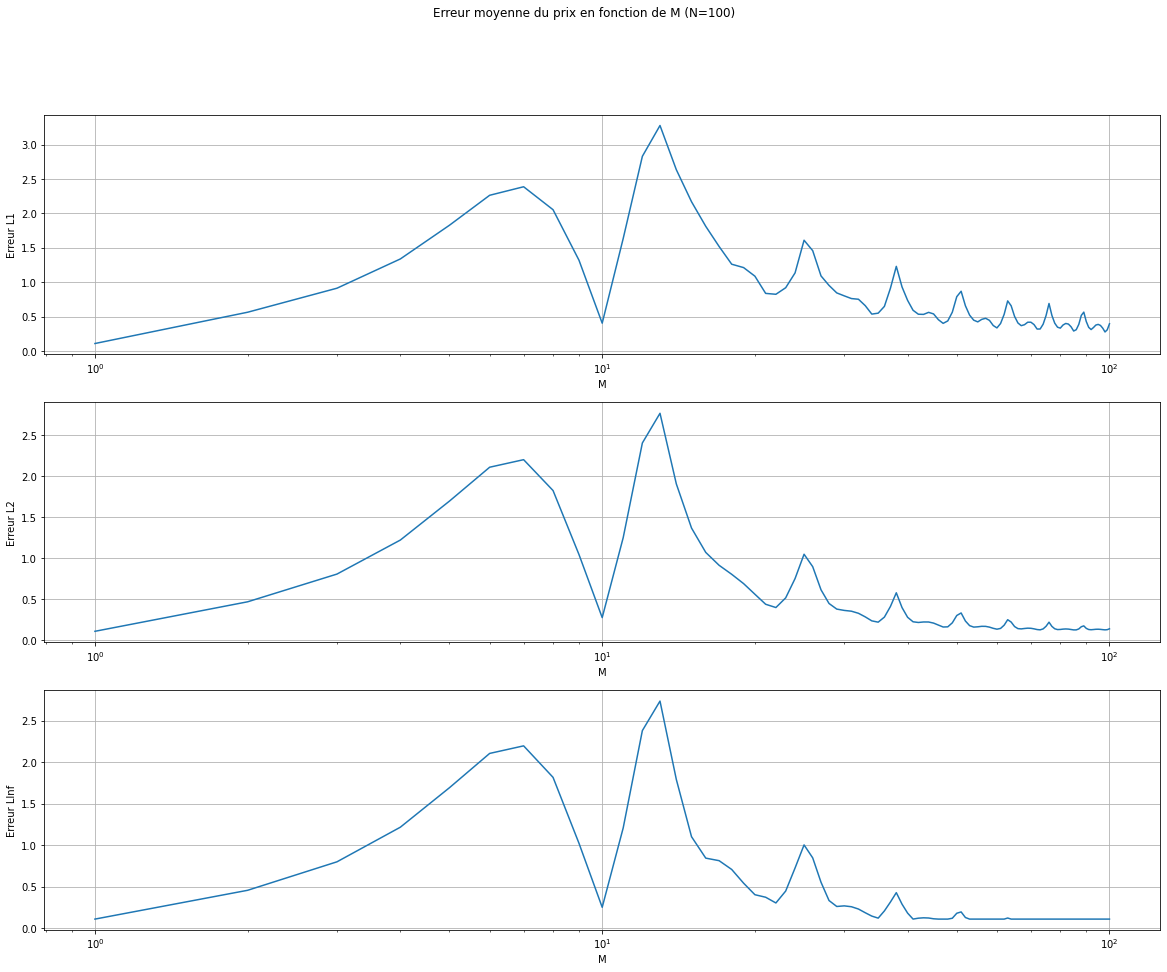

In [22]:
# Initialise the results matrix and space vector
vec_M=np.linspace(1,100,100)
mat_error=np.zeros((len(vec_M),3))
log_s_max=5

# Intilize option object for Euler price
call=Call(s_0=100.0, 
                       strike=100.0, 
                       t=1.0, 
                       r=0.05, 
                       sigma=0.2,
                       N=100)

# Iteration on the M values
for i in range(len(vec_M)):
    
    # Initialize the space dimension
    vec_L=np.linspace(0,log_s_max,int(vec_M[i]+1))
    vec_S0=np.exp(vec_L)
    price_BS=np.zeros(len(vec_L))

    # Iteration to get the BS price 
    for j in range(len(vec_L)):
        
        # Initialize option object
        call_BS=Call(s_0=vec_S0[j], 
                               strike=100.0, 
                               t=1.0, 
                               r=0.05, 
                               sigma=0.2)
        
        # BS price
        price_BS[j]=call_BS.price_BS()
    

    # Explicit Euler resolution
    mat_Euler=call.Euler_EDP(L=log_s_max, M=len(vec_L)-1, explicit=True)
        
    # Calculus of the error
    mat_error[i,0]=np.sum(np.abs(mat_Euler[:,-1]-price_BS))
    mat_error[i,1]=np.sqrt(np.sum((mat_Euler[:,-1]-price_BS)**2))
    mat_error[i,2]=np.max(np.abs(mat_Euler[:,-1]-price_BS))
        
    
#Plot the graph
print_error_M(vec_M, mat_error)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:256: RuntimeWarning: divide by zero encountered in double_scalars


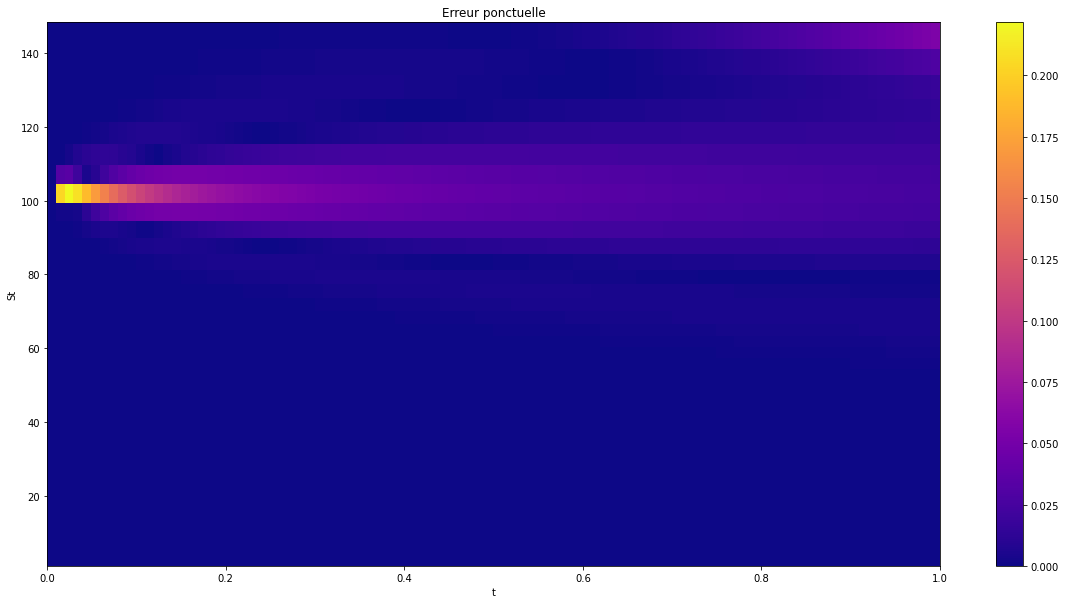

In [23]:
# Intilize option object 
call=Call(s_0=100.0, 
                       strike=100.0, 
                       t=1.0, 
                       r=0.05, 
                       sigma=0.2,
                       N=100)

# Initialize the space and time vector and result matrix
vec_t=np.linspace(0,call.t,101)
vec_S0=np.exp(np.linspace(0,5,101))
price_bs=np.zeros((len(vec_S0),len(vec_t)))

# Explicit Euler resolution
price_euler=call.Euler_EDP(L=5, M=100, explicit=True)

# Double loop to get the BS prices 
for i in range(len(vec_t)):
    
    for j in range(len(vec_S0)):
        
        # Initialize option object
        call_BS=Call(s_0=vec_S0[j], 
                               strike=100.0, 
                               t=vec_t[i], 
                               r=0.05, 
                               sigma=0.2)
        
        price_bs[j,i]=call_BS.price_BS()
        
        
# Complete the results matrix
mat_euler=np.abs(price_euler-price_bs)

# Plot the results
print_error_ponc(vec_S0,vec_t,mat_euler)

## 5. Barrier Option
- Plot the price of the call option with barrier up-out with variation {S_0}
- Plot the price of the call option with maturity increase and verify the convergence.
- Plot the call option with barrier down and in.
- Analyse the variation reduction of the estimation of Monte Carlo 

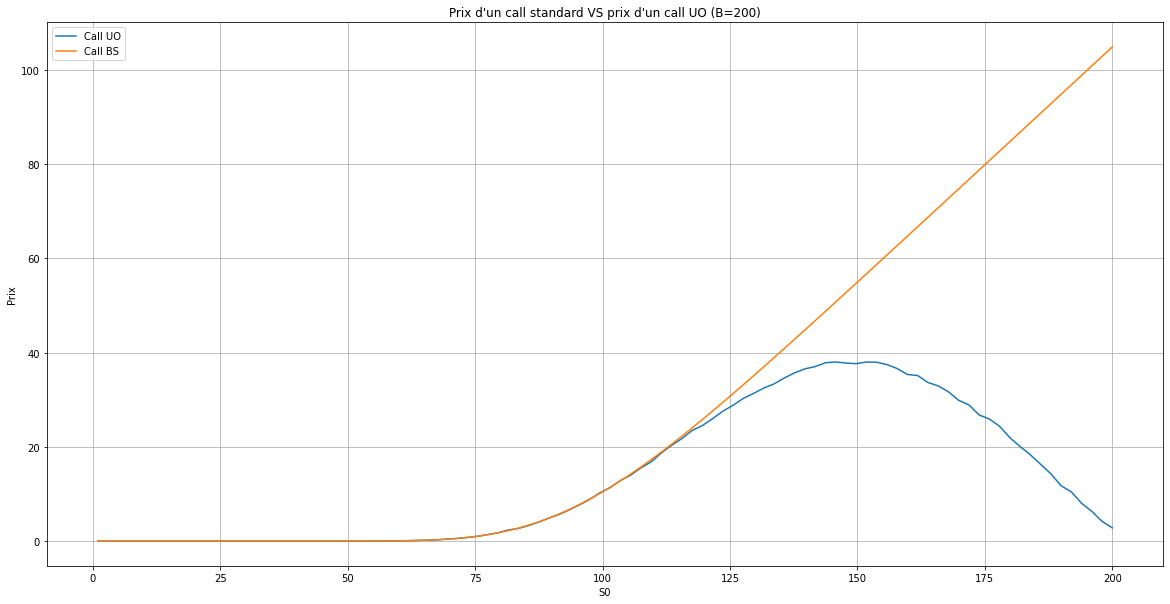

In [25]:
# Initialisation des vecteurs  
vec_S0 = np.linspace(1,200,num=100)
vec_UO=np.zeros(100)
vec_BS=np.zeros(100)

# Iteration sur les valeurs de S0
for i in range(len(vec_S0)):
    
    # Intialisation de l'objet 
    call=Call(s_0=vec_S0[i],strike=100.0,t=1.0,r=0.05,sigma=0.2,N=100,B=200)
    
    # Calcul du prix BS et du prix MC de l'option UO 
    vec_UO[i]=call.barrier_price_monte_carlo(UO=True)[0]
    vec_BS[i]=call.price_BS()

# Representation graphique
print_UO_S0(vec_S0, vec_UO, vec_BS)


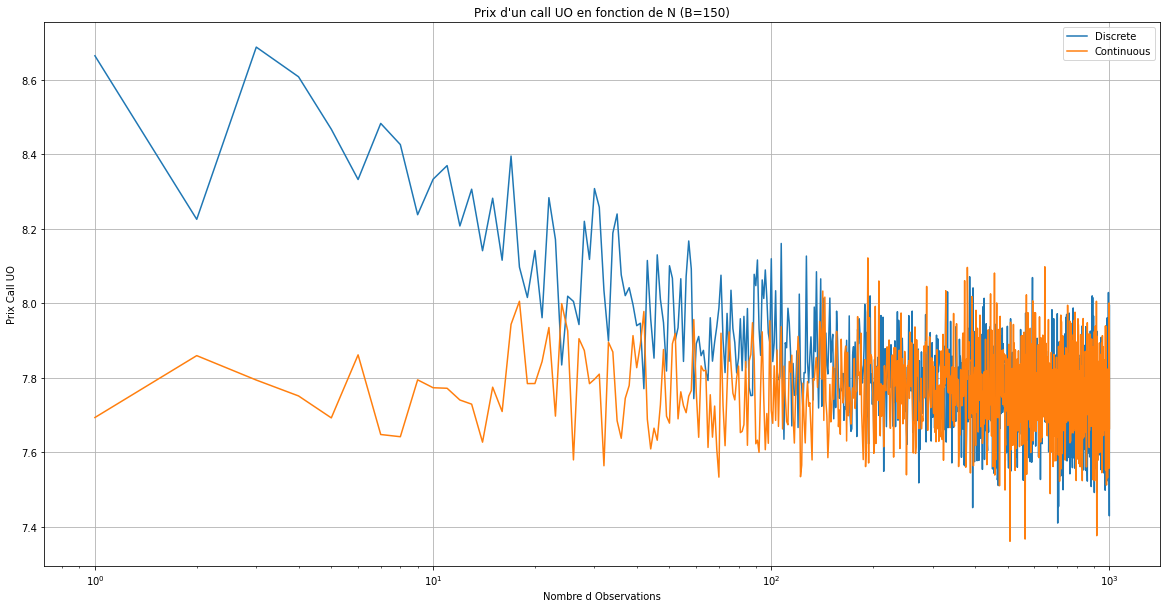

In [26]:
# Initialisation des vecteurs  
vec_N = np.linspace(1,1000,num=1000)
vec_UO=np.zeros(len(vec_N))
vec_UO_cont=np.zeros(len(vec_N))

# Iteration sur les valeurs de N
for i in range(len(vec_N)):
    
    # Intialisation de l'objet 
    call=Call(s_0=100,
                           strike=100.0,
                           t=1.0,
                           r=0.05,
                           sigma=0.2,
                           number_of_simulations=10000,
                           N=int(vec_N[i]),
                           B=150)
    
    # Calcul du prix MC de l'option UO discrete et continue 
    vec_UO[i]=call.barrier_price_monte_carlo(UO=True)[0]
    vec_UO_cont[i]=call.barrier_price_monte_carlo_continuous()[0]

# Representation graphique
print_UO_N(vec_N, vec_UO,vec_UO_cont)

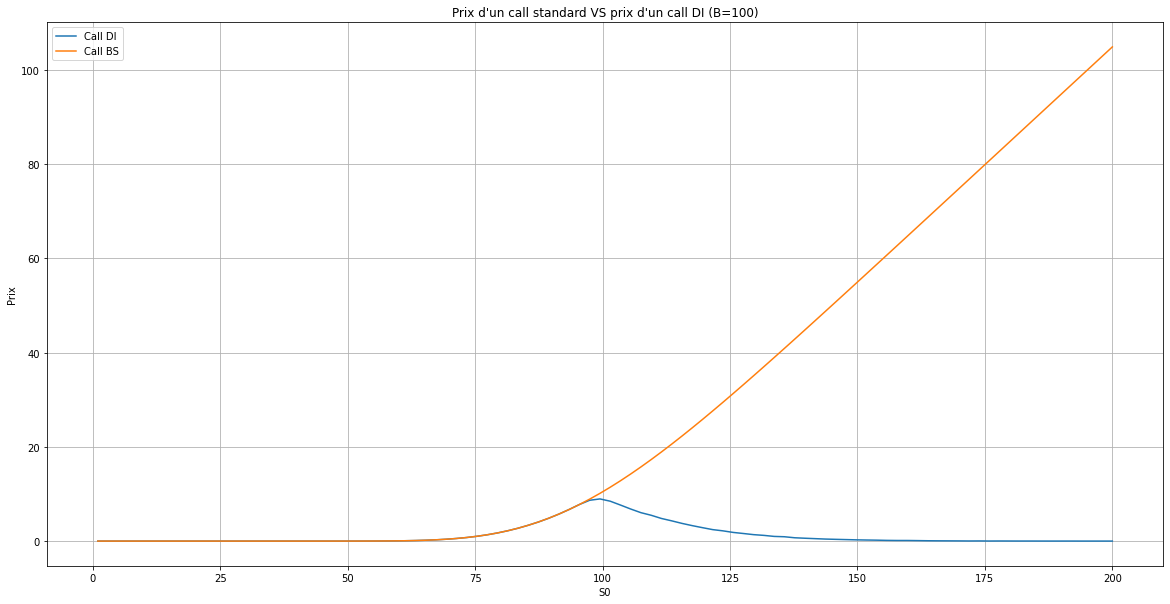

In [27]:
# Initialisation des vecteurs  
vec_S0 = np.linspace(1,200,num=100)
vec_DI=np.zeros(100)
vec_BS=np.zeros(100)

# Iteration sur les valeurs de S0
for i in range(len(vec_S0)):
    
    # Intialisation de l'objet 
    call=Call(s_0=vec_S0[i],strike=100.0,t=1.0,r=0.05,sigma=0.2,N=100,B=100)
    
    # Calcul du prix BS et du prix MC de l'option UO 
    vec_DI[i]=call.barrier_price_monte_carlo_cond()[0]
    vec_BS[i]=call.price_BS()

# Representation graphique
print_DI_S0(vec_S0, vec_DI, vec_BS)

In [29]:
""" Dans cette partie, le but est de révéler la réduction de la variance de 
    l'estimateur du prix avec un Monte Carlo conditionnel. Nous lançons les 
    deux estimateurs avec un grand nombre de simulations (100 000). """

# Intialisation de l'objet 
call=Call(s_0=100,
                       strike=100.0,
                       t=1.0,r=0.05,
                       sigma=0.2,
                       number_of_simulations=100000,
                       N=100,
                       B=100)
    
# Calcul du prix MC et MC Condi de l'option DI 
price_DI=call.barrier_price_monte_carlo(UO=False)
price_DI_condi=call.barrier_price_monte_carlo_cond()

# Representation graphique
print('Variance de l estimateur du prix Call DI MC : %.4f' % (np.var(price_DI[1])))
print('Variance de l estimateur du prix Call DI MC Conditionnel : %.4f' % (np.var(price_DI_condi[1])))
print('')

Variance de l estimateur du prix Call DI MC : 180.2655
Variance de l estimateur du prix Call DI MC Conditionnel : 5.9573



## 6. Euler Method
- Solve the Black-Scholes Equation with Euler method and Milstein method, and plot the convergence.
- Calculate the price of call with Hestion model and Euler method
- Calculate the implied volatility
- Plot the implied volatility - volatility smile with Heston method
- Decompose of the volatility smile with parameters of the volatility (alpha, nu, rho).

In [30]:
""" Dans cette partie, nous allons, pour plusieurs taille de discrétisation, 
    comparer l'erreur forte et faible du schema d'Euler et de Milstein. 
    Le nombre de simulation MC sera de 10 000 ici afin de ne pas surcharger 
    la mémoire. """

# Initialisation des vecteur et matrice 
vec_N=np.linspace(1,1000,num=1000)
vec_err_forte=np.zeros((len(vec_N),2))
vec_err_faible=np.zeros((len(vec_N),2))

for i in range(len(vec_N)):
    
    call=Call(s_0=100.0, strike=100.0, t=1.0, r=0.05,sigma=0.2,number_of_simulations = 10000 , N=int(vec_N[i]))
    price=call.discretisation()
    
    vec_err_forte[i,0]=np.mean(np.abs(price[2][-1]-price[0][-1]))
    vec_err_faible[i,0]=np.abs(np.mean(price[0][-1])-np.mean(price[2][-1]))
    
    vec_err_forte[i,1]=np.mean(np.abs(price[2][-1]-price[1][-1]))
    vec_err_faible[i,1]=np.abs(np.mean(price[1][-1])-np.mean(price[2][-1]))


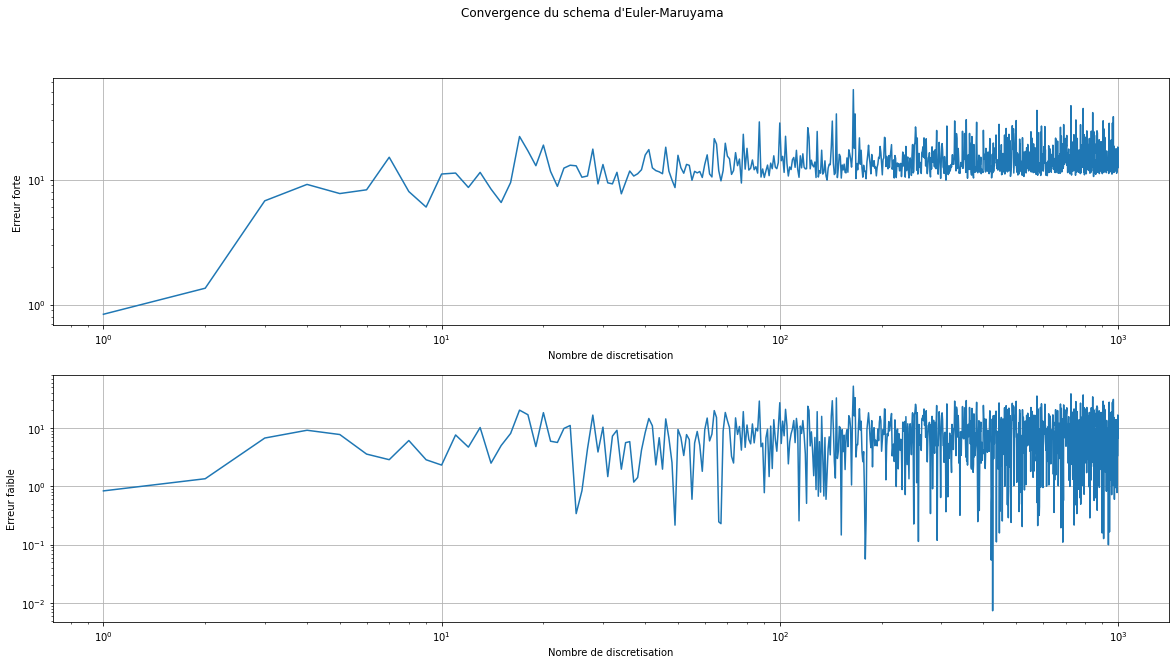

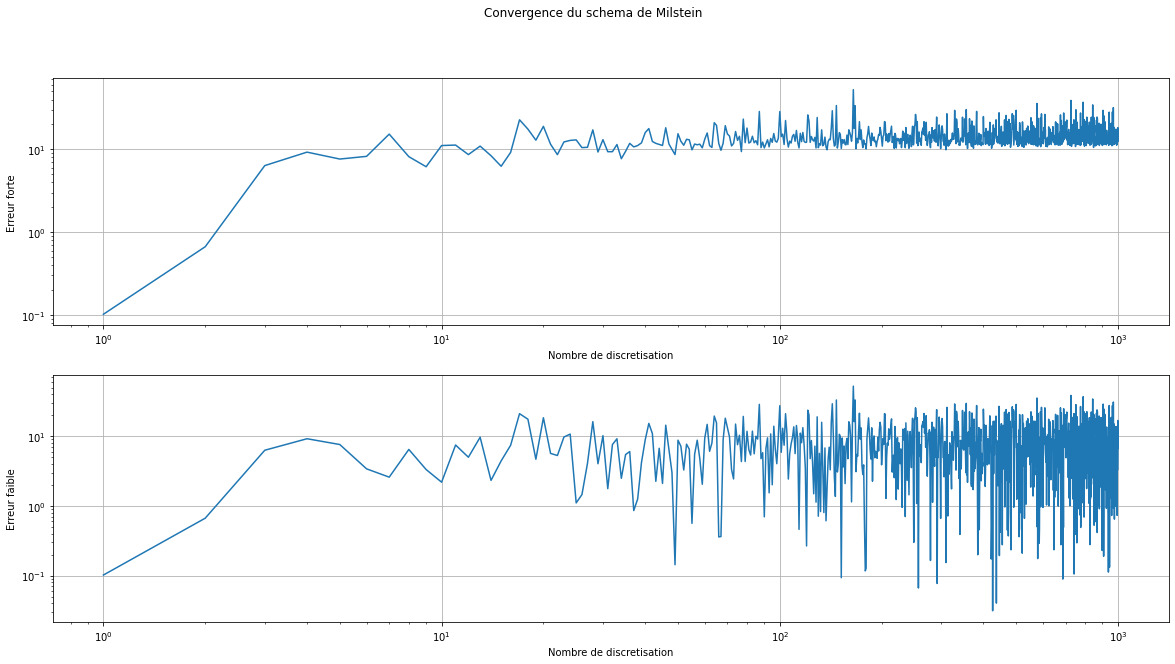

In [31]:
print_conv_Euler(vec_N, vec_err_forte[:,0], vec_err_faible[:,0])
print_conv_Milstein(vec_N, vec_err_forte[:,1], vec_err_faible[:,1])

In [32]:
call=Call(s_0=100.0, strike=100.0, t=1.0, r=0.05, N=10)
heston_price=call.heston_price_monte_carlo(rho=-0.7,alpha=1,nu=0.5,v=0.04)

In [33]:
''' Nous allons pour differente valeur de maturite et de strike, retrouver la 
    volatilite implicite de B&S par dichotomie. Les paramètres inchange du modele 
    seront : S0=100, r = 0.05, v=0.04, lambda = 1, nu = 0.5, rho = -0.7
    Lambda sera appelé alpha dans notre code. '''
 
# Initialisation des paramètres
vec_K = np.linspace(60,150,num=10)
vec_T = np.linspace(1, 10,num=10)
mat_implied_vol=np.zeros((len(vec_K),len(vec_T)))
epsilon=0.01

# Iteration sur les K
for i in range(len(vec_K)):
    
    # Iteration sur les T
    for j in range(len(vec_T)):
        
        # Initialisation du prix Heston 
        call_heston=Call(s_0=100.0,strike=vec_K[i],t=vec_T[j],r=0.05,N=100)
        heston_price=call_heston.heston_price_monte_carlo(rho=-0.7,alpha=1,nu=0.5,v=0.04)
        
        # Initialisation de la dichotomie
        sigma1=0.0001
        sigma2=1.0
        sigmam=(sigma1+sigma2)/2
        
        call1=Call(s_0=100.0,strike=vec_K[i],t=vec_T[j],r=0.05,sigma=sigma1)
        call2=Call(s_0=100.0,strike=vec_K[i],t=vec_T[j],r=0.05,sigma=sigma2)
        callm=Call(s_0=100.0,strike=vec_K[i],t=vec_T[j],r=0.05,sigma=sigmam)
    
        bs_price1=call1.price_BS()
        bs_price2=call2.price_BS()
        bs_pricem=callm.price_BS()
        
        # Boucle while 
        while abs(bs_pricem-heston_price[0])>=epsilon:
            
            if (bs_price1<=heston_price[0]) and (heston_price[0]<=bs_pricem):
                
                sigma2=sigmam
                sigmam=(sigma1+sigma2)/2
                call2=Call(s_0=100.0,strike=vec_K[i],t=vec_T[j],r=0.05,sigma=sigma2)
                callm=Call(s_0=100.0,strike=vec_K[i],t=vec_T[j],r=0.05,sigma=sigmam)
                bs_price2=call2.price_BS()
                bs_pricem=callm.price_BS()
                
            elif (bs_price2>=heston_price[0]) and (heston_price[0]>=bs_pricem):
                sigma1=sigmam
                sigmam=(sigma1+sigma2)/2
                call1=Call(s_0=100.0,strike=vec_K[i],t=vec_T[j],r=0.05,sigma=sigma1)
                callm=Call(s_0=100.0,strike=vec_K[i],t=vec_T[j],r=0.05,sigma=sigmam)
                bs_price1=call1.price_BS()
                bs_pricem=callm.price_BS()
                
            else :

                print('Maturite : %.2f' % vec_T[j])
                print('Strike : %.2f' % vec_K[i])
                print('Prix BS High : %.2f' % bs_price1)
                print('Prix BS Low : %.2f' % bs_price2)
                print('Prix Heston : %.2f' % heston_price[0])
                print("NO CONVERGENCE")
                break

        mat_implied_vol[i,j]=sigmam


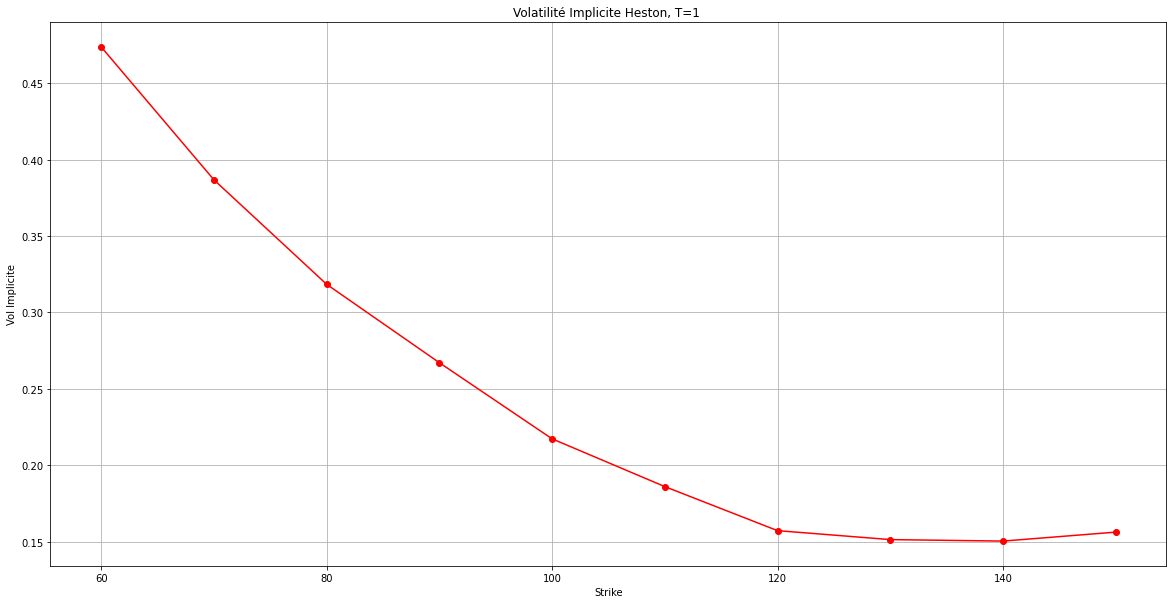

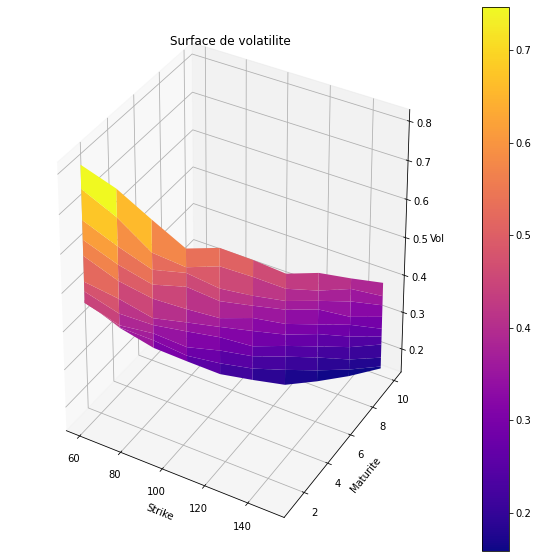

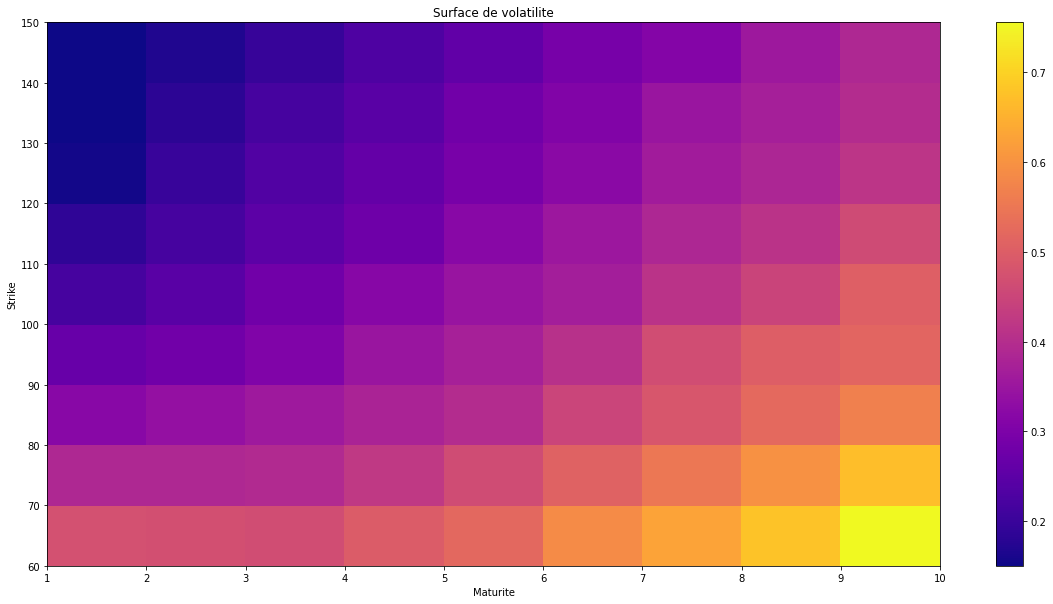

In [34]:
plot_smile_vol(vec_K, mat_implied_vol[:,0])
plot_nappe_vol(vec_K, vec_T, np.transpose(mat_implied_vol))
plot_color_map(vec_K,vec_T,mat_implied_vol)


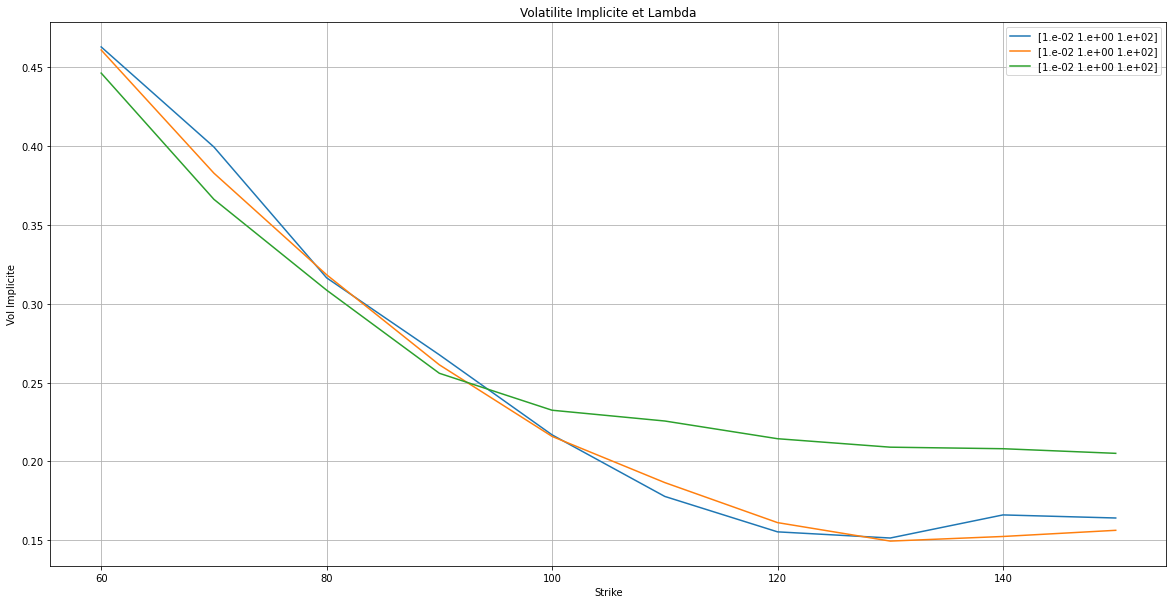

In [35]:
# A) LAMBDA

vec_lambda=np.array([0.01, 1, 100])
mat_implied_vol_lambda=np.zeros((len(vec_K),len(vec_lambda)))
                            
for j in range(len(vec_lambda)):

    for i in range(len(vec_K)):

        # Initialisation du prix Heston 
        call_heston=Call(s_0=100.0,strike=vec_K[i],t=1.0,r=0.05,N=100)
        heston_price=call_heston.heston_price_monte_carlo(rho=-0.7,alpha=vec_lambda[j],nu=0.5,v=0.04)
        
        # Initialisation de la dichotomie
        sigma1=0.0001
        sigma2=1.0
        sigmam=(sigma1+sigma2)/2
        
        call1=Call(s_0=100.0,strike=vec_K[i],t=1.0,r=0.05,sigma=sigma1)
        call2=Call(s_0=100.0,strike=vec_K[i],t=1.0,r=0.05,sigma=sigma2)
        callm=Call(s_0=100.0,strike=vec_K[i],t=1.0,r=0.05,sigma=sigmam)
    
        bs_price1=call1.price_BS()
        bs_price2=call2.price_BS()
        bs_pricem=callm.price_BS()
        
        # Boucle while 
        while abs(bs_pricem-heston_price[0])>=epsilon:
            
            if (bs_price1<=heston_price[0]) and (heston_price[0]<=bs_pricem):
                
                sigma2=sigmam
                sigmam=(sigma1+sigma2)/2
                call2=Call(s_0=100.0,strike=vec_K[i],t=1.0,r=0.05,sigma=sigma2)
                callm=Call(s_0=100.0,strike=vec_K[i],t=1.0,r=0.05,sigma=sigmam)
                bs_price2=call2.price_BS()
                bs_pricem=callm.price_BS()
                
            elif (bs_price2>=heston_price[0]) and (heston_price[0]>=bs_pricem):
                sigma1=sigmam
                sigmam=(sigma1+sigma2)/2
                call1=Call(s_0=100.0,strike=vec_K[i],t=1.0,r=0.05,sigma=sigma1)
                callm=Call(s_0=100.0,strike=vec_K[i],t=1.0,r=0.05,sigma=sigmam)
                bs_price1=call1.price_BS()
                bs_pricem=callm.price_BS()
                
            else :
                
                print('Lambda : %.2f' % vec_lambda[j])
                print('Strike : %.2f' % vec_K[i])
                print('Prix BS High : %.2f' % bs_price1)
                print('Prix BS Low : %.2f' % bs_price2)
                print('Prix Heston : %.2f' % heston_price[0])
                print("NO CONVERGENCE")
                break

        
        mat_implied_vol_lambda[i,j]=sigmam

print_vol_lambda(vec_lambda,vec_K,mat_implied_vol_lambda)

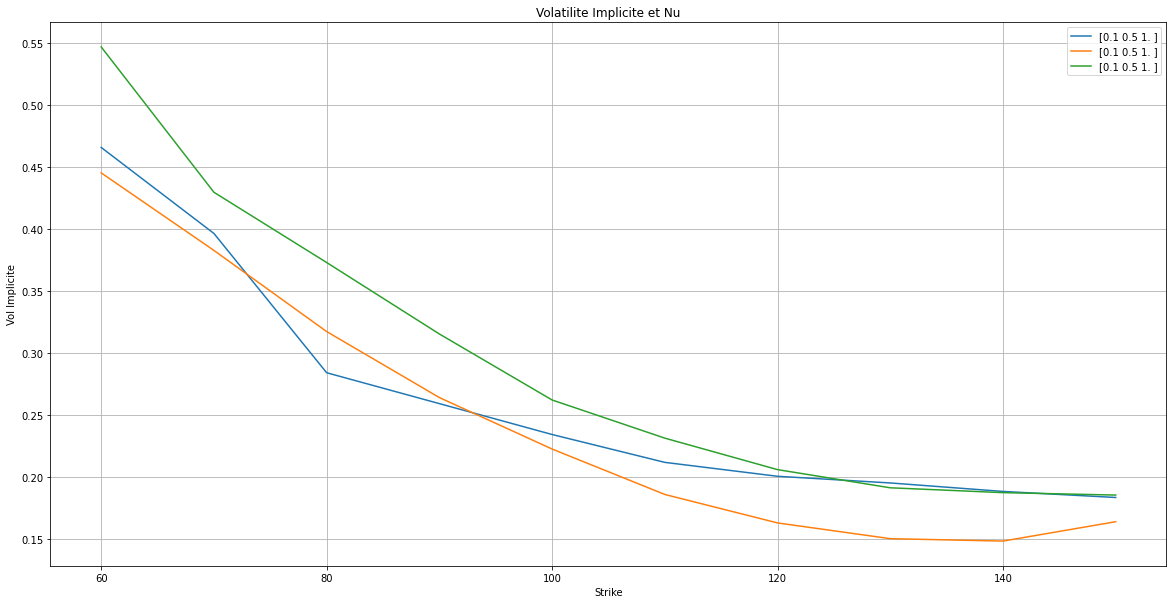

In [37]:
# B) NU

vec_nu=np.array([0.1, 0.5, 1])
mat_implied_vol_nu=np.zeros((len(vec_K),len(vec_nu)))
                            
for j in range(len(vec_nu)):

    for i in range(len(vec_K)):

        # Initialisation du prix Heston 
        call_heston=Call(s_0=100.0,strike=vec_K[i],t=1.0,r=0.05,N=100)
        heston_price=call_heston.heston_price_monte_carlo(rho=-0.7,
                                                          alpha=1.0,
                                                          nu=vec_nu[j],
                                                          v=0.04)
        # Initialisation de la dichotomie
        sigma1=0.0001
        sigma2=1.0
        sigmam=(sigma1+sigma2)/2
        
        call1=Call(s_0=100.0,strike=vec_K[i],t=1.0,r=0.05,sigma=sigma1)
        call2=Call(s_0=100.0,strike=vec_K[i],t=1.0,r=0.05,sigma=sigma2)
        callm=Call(s_0=100.0,strike=vec_K[i],t=1.0,r=0.05,sigma=sigmam)
    
        bs_price1=call1.price_BS()
        bs_price2=call2.price_BS()
        bs_pricem=callm.price_BS()
        
        # Boucle while 
        while abs(bs_pricem-heston_price[0])>=epsilon:
            
            if (bs_price1<=heston_price[0]) and (heston_price[0]<=bs_pricem):
                
                sigma2=sigmam
                sigmam=(sigma1+sigma2)/2
                call2=Call(s_0=100.0,strike=vec_K[i],t=1.0,r=0.05,sigma=sigma2)
                callm=Call(s_0=100.0,strike=vec_K[i],t=1.0,r=0.05,sigma=sigmam)
                bs_price2=call2.price_BS()
                bs_pricem=callm.price_BS()
                
            elif (bs_price2>=heston_price[0]) and (heston_price[0]>=bs_pricem):
                sigma1=sigmam
                sigmam=(sigma1+sigma2)/2
                call1=Call(s_0=100.0,strike=vec_K[i],t=1.0,r=0.05,sigma=sigma1)
                callm=Call(s_0=100.0,strike=vec_K[i],t=1.0,r=0.05,sigma=sigmam)
                bs_price1=call1.price_BS()
                bs_pricem=callm.price_BS()
                
            else :
                
                print('Nu : %.2f' % vec_nu[j])
                print('Strike : %.2f' % vec_K[i])
                print('Prix BS High : %.2f' % bs_price1)
                print('Prix BS Low : %.2f' % bs_price2)
                print('Prix Heston : %.2f' % heston_price[0])
                print("NO CONVERGENCE")
                break
        
        mat_implied_vol_nu[i,j]=sigmam

print_vol_nu(vec_nu,vec_K,mat_implied_vol_nu)


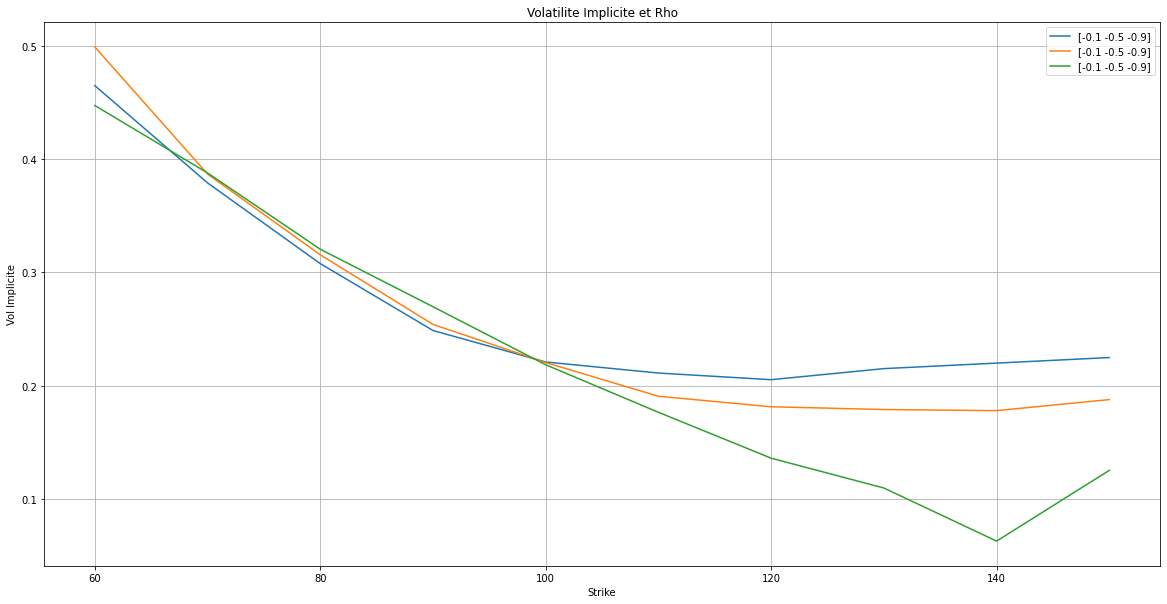

In [36]:
# C) RHO
call=option_class.Call(s_0=100.0,strike=100,t=1.0,r=0.05,number_of_simulations=100000)
mat_v=call.euler_trans_density(rho=-0.7,alpha=1,nu=0.5,v=0.04)

fonctions_divers.print_hist_sigma(mat_v)
vec_rho=np.array([-0.1, -0.5, -0.9])
mat_implied_vol_rho=np.zeros((len(vec_K),len(vec_rho)))
                            
for j in range(len(vec_rho)):

    for i in range(len(vec_K)):

        # Initialisation du prix Heston 
        call_heston=Call(s_0=100.0,strike=vec_K[i],t=1.0,r=0.05,N=100)
        heston_price=call_heston.heston_price_monte_carlo(rho=vec_rho[j],
                                                          alpha=1.0,
                                                          nu=0.5,
                                                          v=0.04)
        # Initialisation de la dichotomie
        sigma1=0.0001
        sigma2=1.0
        sigmam=(sigma1+sigma2)/2
        
        call1=Call(s_0=100.0,strike=vec_K[i],t=1.0,r=0.05,sigma=sigma1)
        call2=Call(s_0=100.0,strike=vec_K[i],t=1.0,r=0.05,sigma=sigma2)
        callm=Call(s_0=100.0,strike=vec_K[i],t=1.0,r=0.05,sigma=sigmam)
    
        bs_price1=call1.price_BS()
        bs_price2=call2.price_BS()
        bs_pricem=callm.price_BS()
        
        # Boucle while 
        while abs(bs_pricem-heston_price[0])>=epsilon:
            
            if (bs_price1<=heston_price[0]) and (heston_price[0]<=bs_pricem):
                
                sigma2=sigmam
                sigmam=(sigma1+sigma2)/2
                call2=Call(s_0=100.0,strike=vec_K[i],t=1.0,r=0.05,sigma=sigma2)
                callm=Call(s_0=100.0,strike=vec_K[i],t=1.0,r=0.05,sigma=sigmam)
                bs_price2=call2.price_BS()
                bs_pricem=callm.price_BS()
                
            elif (bs_price2>=heston_price[0]) and (heston_price[0]>=bs_pricem):
                sigma1=sigmam
                sigmam=(sigma1+sigma2)/2
                call1=Call(s_0=100.0,strike=vec_K[i],t=1.0,r=0.05,sigma=sigma1)
                callm=Call(s_0=100.0,strike=vec_K[i],t=1.0,r=0.05,sigma=sigmam)
                bs_price1=call1.price_BS()
                bs_pricem=callm.price_BS()
                
            else :
                
                print('Nu : %.2f' % vec_nu[j])
                print('Strike : %.2f' % vec_K[i])
                print('Prix BS High : %.2f' % bs_price1)
                print('Prix BS Low : %.2f' % bs_price2)
                print('Prix Heston : %.2f' % heston_price[0])
                print("NO CONVERGENCE")
                break
        
        mat_implied_vol_rho[i,j]=sigmam

print_vol_rho(vec_rho,vec_K,mat_implied_vol_rho)

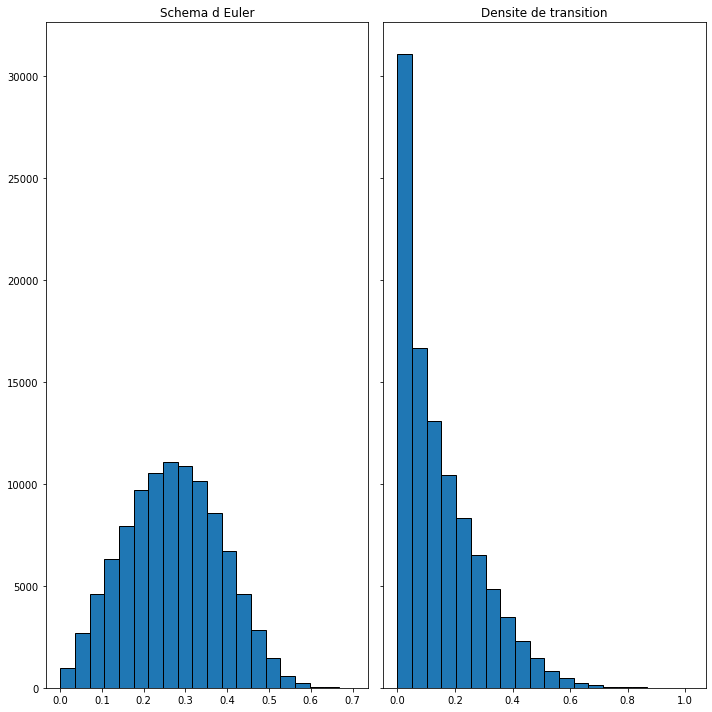

In [38]:
call=Call(s_0=100.0,strike=100,t=1.0,r=0.05,number_of_simulations=100000)
mat_v=call.euler_trans_density(rho=-0.7,alpha=1,nu=0.5,v=0.04)

print_hist_sigma(mat_v)